## Problem Statement

Businesses in Google Maps are often tagged under multiple categories. We need each business to map to a single, general category to have sufficient test/train data. We used two methods for recategorization: 
1. Pearson correlation based on category relationships in the data
2. KeyedVector from a pretrained NLP model in `gensim`

We chose general categories based on which raw categories appear most in the business data. For instance, "auto repair shop" was a common category, which we used to define the general "auto" category.

### Load raw dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy

yolosac = pd.read_csv('data/yolosac.csv')
yolosac['category'] = yolosac['category'].apply(eval).map(lambda x : [cat.lower() for cat in x])
print (yolosac['category'])

0                                      [massage therapist]
1                                      [massage therapist]
2                                          [door supplier]
3                                                 [church]
4                                                 [church]
                               ...                        
17933                                [american restaurant]
17934                                        [gas station]
17935                                      [movie theater]
17936                                   [pizza restaurant]
17937    [electronics store, appliance store, computer ...
Name: category, Length: 17938, dtype: object


Print the top 30 raw business categories.

In [99]:
# Top 30 business categories
print(yolosac['category'].explode().value_counts().iloc[:30])
yolosac['category'].explode().value_counts().to_csv('data/business_categories.csv')

category
restaurant              1352
fast food restaurant     649
auto repair shop         513
park                     463
mexican restaurant       429
beauty salon             428
takeout restaurant       411
coffee shop              394
grocery store            382
breakfast restaurant     380
gas station              377
hair salon               364
sandwich shop            359
cafe                     353
american restaurant      347
tourist attraction       322
pizza restaurant         320
caterer                  319
nail salon               318
convenience store        310
hamburger restaurant     285
bar                      285
clothing store           260
cell phone store         235
tire shop                222
barber shop              211
atm                      210
used car dealer          209
chinese restaurant       207
auto parts store         199
Name: count, dtype: int64


**Trends:**
- Restaurant categories show up frequently
- Auto repair shops are the second most common, after restaurants
- Parks, beauty salons, and grocery stores are in the top 10 most common categories
- Clothing stores are within the top 30 most common categories

### Calculate Pearson correlation between raw categories

#### One Hot Encoding

In [2]:
# Credit: https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173
def bool_df(item_lists, unique_items):
  bool_dict = {}
  # Iterate over all tags
  for i, item in enumerate(unique_items):
    # Apply Boolean mask
    bool_dict[item] = item_lists.apply(lambda x: item in x)
  
  # Return as dataframe
  return pd.DataFrame(bool_dict)

In [3]:
# List of unique business categories with frequency
unique_cat_freq = pd.DataFrame(yolosac['category'].explode().value_counts())

unique_cat_freq.index = unique_cat_freq.index.map(lambda x : x.lower())

unique_cat_freq.reset_index(level=0, inplace=True)
unique_cat_freq.rename(columns={'index' : 'category'}, inplace=True)
# Generate boolean matrix where each category is a column (one hot encoding)
categories_bool = bool_df(item_lists=yolosac['category'], unique_items=unique_cat_freq['category'])
categories_bool

,restaurant,fast food restaurant,auto repair shop,park,mexican restaurant,beauty salon,takeout restaurant,coffee shop,grocery store,breakfast restaurant,...,cosmetics industry,airbrushing service,leasing service,optical wholesaler,drilling contractor,chinese medicine clinic,religious school,athletic park,pulmonologist,wildlife park
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17933,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17934,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17935,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17936,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Generate Correlation Matrix between raw buiness categories

In [5]:
# Generate correlation table between categories (takes ~2 mins)
categories_corr = categories_bool.corr(method="pearson")
categories_corr

,restaurant,fast food restaurant,auto repair shop,park,mexican restaurant,beauty salon,takeout restaurant,coffee shop,grocery store,breakfast restaurant,...,cosmetics industry,airbrushing service,leasing service,optical wholesaler,drilling contractor,chinese medicine clinic,religious school,athletic park,pulmonologist,wildlife park
restaurant,1.000000,0.345007,-0.048988,-0.046473,0.128078,-0.043253,0.300653,0.065274,-0.034801,0.180908,...,-0.002132,-0.002132,-0.002132,-0.002132,-0.002132,-0.002132,-0.002132,-0.002132,-0.002132,-0.002132
fast food restaurant,0.345007,1.000000,-0.033244,-0.031537,0.186558,-0.028335,0.427238,0.101322,-0.028580,0.294913,...,-0.001447,-0.001447,-0.001447,-0.001447,-0.001447,-0.001447,-0.001447,-0.001447,-0.001447,-0.001447
auto repair shop,-0.048988,-0.033244,1.000000,-0.027929,-0.026858,-0.026826,-0.026275,-0.025713,-0.025310,-0.025242,...,-0.001281,-0.001281,-0.001281,-0.001281,-0.001281,-0.001281,-0.001281,-0.001281,-0.001281,-0.001281
park,-0.046473,-0.031537,-0.027929,1.000000,-0.025479,-0.025448,-0.024926,-0.024393,-0.024010,-0.023946,...,-0.001215,-0.001215,-0.001215,-0.001215,-0.001215,-0.001215,-0.001215,-0.001215,-0.001215,0.045872
mexican restaurant,0.128078,0.186558,-0.026858,-0.025479,1.000000,-0.024472,0.127223,-0.023458,-0.010453,0.118869,...,-0.001169,-0.001169,-0.001169,-0.001169,-0.001169,-0.001169,-0.001169,-0.001169,-0.001169,-0.001169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chinese medicine clinic,-0.002132,-0.001447,-0.001281,-0.001215,-0.001169,-0.001167,-0.001143,-0.001119,-0.001101,-0.001098,...,-0.000056,-0.000056,-0.000056,-0.000056,-0.000056,1.000000,-0.000056,-0.000056,-0.000056,-0.000056
religious school,-0.002132,-0.001447,-0.001281,-0.001215,-0.001169,-0.001167,-0.001143,-0.001119,-0.001101,-0.001098,...,-0.000056,-0.000056,-0.000056,-0.000056,-0.000056,-0.000056,1.000000,-0.000056,-0.000056,-0.000056
athletic park,-0.002132,-0.001447,-0.001281,-0.001215,-0.001169,-0.001167,-0.001143,-0.001119,-0.001101,-0.001098,...,-0.000056,-0.000056,-0.000056,-0.000056,-0.000056,-0.000056,-0.000056,1.000000,-0.000056,-0.000056
pulmonologist,-0.002132,-0.001447,-0.001281,-0.001215,-0.001169,-0.001167,-0.001143,-0.001119,-0.001101,-0.001098,...,-0.000056,-0.000056,-0.000056,-0.000056,-0.000056,-0.000056,-0.000056,-0.000056,1.000000,-0.000056


### Import KeyedVector from `gensim`

In [ ]:
import gensim.downloader as api
# Credit: https://nlp.stanford.edu/projects/glove/
key_vec = api.load('glove-wiki-gigaword-100')
key_vec.most_similar('restaurant')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oliviashen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Generate Lists of General Categories

Extract the names of "raw categories" that fall into the following general categories:
1. Education -- schools
2. Health -- doctors, pharmacies
3. Beauty -- salons
4. Recreation -- parks, gyms, sports, venues
5. Grocery -- grocery stores, supermarkets
6. Retail -- clothing, furniture, home goods
7. Auto -- repair shops, dealerships
8. Restaurant -- restaurants, cafes, bars

### Using the Correlation Matrix

For certain categories, we will group similar terms based on whether they appear together in the category list of businesses. If raw categories appear together often, they are likely in the same general category.

In [6]:
# Helper function to extract similar categories
def similarCats(cat):
  return categories_corr[str(cat)].sort_values(ascending=False).loc[categories_corr[str(cat)] > 0].index.to_list()

### Extract simplified business categories

In [7]:
restaurant = similarCats('restaurant')
print(*restaurant, sep='\n')

restaurant
fast food restaurant
sandwich shop
takeout restaurant
caterer
hamburger restaurant
lunch restaurant
american restaurant
breakfast restaurant
tex-mex restaurant
bar
burrito restaurant
taco restaurant
asian restaurant
vegetarian restaurant
mexican restaurant
chinese restaurant
salad shop
diner
steak house
family restaurant
seafood restaurant
bar & grill
hot dog restaurant
californian restaurant
japanese restaurant
gastropub
brunch restaurant
deli
cajun restaurant
sports bar
juice shop
european restaurant
pasta shop
box lunch supplier
barbecue restaurant
coffee shop
sushi restaurant
fine dining restaurant
chicken wings restaurant
hot dog stand
down home cooking restaurant
italian restaurant
cafeteria
traditional american restaurant
soup restaurant
new american restaurant
delivery restaurant
thai restaurant
vietnamese restaurant
buffet restaurant
mediterranean restaurant
grill
pizza restaurant
bistro
greek restaurant
catering food and drink supplier
pretzel store
catering
brewpu

In [108]:

for i in restaurant:
  print(i, categories_bool[i].value_counts()[True])

restaurant 1352
fast food restaurant 649
sandwich shop 359
takeout restaurant 411
caterer 319
hamburger restaurant 285
lunch restaurant 86
american restaurant 347
breakfast restaurant 380
tex-mex restaurant 61
bar 285
burrito restaurant 65
taco restaurant 81
asian restaurant 150
vegetarian restaurant 124
mexican restaurant 429
chinese restaurant 207
salad shop 58
diner 70
steak house 43
family restaurant 147
seafood restaurant 114
bar & grill 93
hot dog restaurant 27
californian restaurant 18
japanese restaurant 111
gastropub 15
brunch restaurant 38
deli 121
cajun restaurant 19
sports bar 54
juice shop 66
european restaurant 11
pasta shop 7
box lunch supplier 9
barbecue restaurant 46
coffee shop 394
sushi restaurant 92
fine dining restaurant 19
chicken wings restaurant 100
hot dog stand 7
down home cooking restaurant 7
italian restaurant 153
cafeteria 8
traditional american restaurant 8
soup restaurant 28
new american restaurant 21
delivery restaurant 100
thai restaurant 78
vietnamese 

In [54]:
hotel = similarCats('hotel')
hotel.remove('bar')
hotel.remove('boutique')
hotel.remove('army facility')
print(*hotel, sep='\n')

hotel
indoor lodging
lodge
extended stay hotel
meeting planning service
motel
inn
bed & breakfast
wedding venue
gambling house
function room facility
event venue
meeting room
lodging
casino
banquet hall
conference center
business center


In [9]:
yolosac[categories_bool['Hotel'] & categories_bool['Restaurant']]

,name,gmap_id,category,avg_rating,num_of_reviews
14921,Park Winters,0x8084dd62863323ab:0x73b08ffc3fac394,"[Event venue, Bed & breakfast, Hotel, Inn, Res...",4.9,138
16053,Rogelio's Dine & Sleep Inn,0x809aad5d5b95d979:0x27d24a0876dd5d9d,"[Restaurant, Bar, Bed & breakfast, Casino, Chi...",4.2,88


In [10]:
beauty = similarCats('beauty salon')
beauty.remove('organic shop')
beauty.remove('office space rental agency')
beauty.remove('trade school')
print(*beauty, sep='\n')

beauty salon
hair salon
waxing hair removal service
hairdresser
nail salon
hair removal service
facial spa
hair care
barber shop
hair extension technician
spa
beauty school
make-up artist
stylist
eyelash salon
beauty supply store
beauty
day spa
permanent make-up clinic
eyebrow bar
beauty product supplier
mehndi designer
cosmetics industry
health and beauty shop
cosmetics store
hair replacement service
massage supply store
barber supply store
wig shop
skin care clinic
hair extensions supplier
barber school
massage therapist
ear piercing service
tanning salon
aromatherapy service
medical spa
body piercing shop
massage spa
reflexologist


In [41]:
car = similarCats('auto repair shop')
print(*car, sep='\n')

auto repair shop
brake shop
oil change service
transmission shop
mechanic
tire shop
car repair and maintenance
auto tune up service
auto air conditioning service
smog inspection station
wheel alignment service
fuel pump
auto electrical service
auto radiator repair service
diesel fuel supplier
wheel store
gas company
engine rebuilding service
diesel engine repair service
auto parts store
muffler shop
auto body shop
radiator shop
radiator repair service
small engine repair service
honda dealer
ford dealer
toyota dealer
auto spring shop
vehicle inspection
truck repair shop
subaru dealer
chauffeur service
used tire shop
car inspection station
car dealer
chevrolet dealer
car battery store
gas station
air conditioning repair service
used car dealer
diagnostic center
bmw dealer
dodge dealer
auto restoration service
jeep dealer
kia dealer
alfa romeo dealer
acura dealer
maserati dealer
hyundai dealer
volkswagen dealer
rv repair shop
auto dent removal service
tuning automobile
car detailing serv

In [113]:
education = similarCats('school')
education.extend(similarCats('college'))
print(*education, sep='\n')

school
educational institution
high school
public educational institution
elementary school
private educational institution
senior high school
primary school
cleaning products supplier
middle school
catholic school
preschool
day care center
school district office
adult education school
restaurant supply store
comedy club
child care agency
after school program
mosque
uniform store
distribution service
non-profit organization
car detailing service
college
computer training school
trade school
medical school
vocational college
graduate school
university
community college
private university
dental school
private college
junior college
business school
law school
technical school
vocational school
nursing school
martial arts school
adult education school
yoga studio
educational institution


In [114]:
health = similarCats('doctor')
health.extend(similarCats('hospital'))
print(*health, sep='\n')

doctor
medical clinic
general practitioner
medical group
community health centre
cardiologist
family practice physician
psychotherapist
walk-in clinic
pediatrician
emergency care physician
psychologist
radiologist
plastic surgeon
medical center
orthopedic surgeon
marriage or relationship counselor
counselor
medical office
emergency care service
wellness center
surgeon
obstetrician-gynecologist
urgent care center
audiologist
chiropractor
mental health clinic
internist
hearing aid store
massage therapist
ophthalmologist
physical therapist
weight loss service
dental clinic
optician
dentist
hospital
specialized hospital
general hospital
emergency room
mental health clinic
medical center
business center
gift shop


In [67]:
retail = similarCats('clothing store')
print(*retail, sep='\n')

clothing store
men's clothing store
women's clothing store
shoe store
department store
children's clothing store
fashion accessories store
jeans shop
t-shirt store
swimwear store
baby store
sporting goods store
sportswear store
outdoor sports store
running store
outlet store
toy store
plus size clothing store
camping store
discount store
baby clothing store
lingerie store
dress store
underwear store
jewelry store
custom t-shirt store
luggage store
sunglasses store
youth clothing store
baseball goods store
electronics store
work clothes store
skateboard shop
home goods store
boutique
skate shop
outdoor clothing and equipment shop
watch store
vintage clothing store
clothes and fabric manufacturer
clothing supplier
outerwear store
novelty store
used clothing store
tuxedo shop
snowboard shop
golf shop
furniture store
western apparel store
craft store
outdoor activity organiser
surf shop
hunting and fishing store
grocery store
clothes market
protective clothing supplier
bicycle store
boot s

In [116]:
grocery = similarCats('grocery store')
print(*grocery, sep='\n')

grocery store
supermarket
produce market
grocery delivery service
discount store
dollar store
toy store
variety store
school supply store
craft store
kitchen supply store
party store
natural goods store
organic food store
discount supermarket
fruit and vegetable store
home goods store
health food store
department store
warehouse store
gourmet grocery store
meat products
fresh food market
wholesale grocer
store
baby store
butcher shop
deli
cheese shop
wholesaler
bakery
seafood market
asian grocery store
market
outlet store
indian grocery store
electronics store
spice store
wine store
mexican grocery store
farmers' market
truck stop
afghani restaurant
clothing store
sporting goods store
liquor store
furniture store
japanese grocery store
russian grocery store
convenience store
coffee vending machine
agriculture
wine
beer store
florist
middle eastern restaurant
halal restaurant
korean grocery store
propane supplier
vitamin & supplements store
sports nutrition store
e-commerce service
ware

In [117]:
rec = similarCats('park')
print(*rec, sep='\n')

park
tourist attraction
baseball field
recreation
basketball court
playground
tennis court
softball field
amphitheater
wildlife park
scenic spot
fishing pond
fountain
animals
soccer field
amusement park
state park
amusement park ride
hockey rink
dog park
skateboard park
government
baseball
zoo
theme park
picnic ground
recreation center
corporate campus
wildlife refuge
city park
memorial park
golf instructor
golf club
pumpkin patch
ranch
swimming pool
nature preserve
public golf course
sports equipment rental service
auditorium
children's amusement center
event venue
golf course
amusement center
public swimming pool
government office
sports complex
wedding venue
live music venue


In [17]:
yolosac[categories_bool['ATM'] & ~(categories_bool['Bank'] | categories_bool['Gas station'])]

,name,gmap_id,category,avg_rating,num_of_reviews
83,Bank of America ATM,0x80852903058f1645:0x23304ec837207bc3,[ATM],4.0,2
201,Bank of America ATM,0x80852903058f1645:0x23304ec837207bc3,[ATM],4.0,2
548,Bank of America ATM (Drive-thru),0x809b277f9207d47b:0x41e30805fe829932,[ATM],2.5,8
563,Chase ATM,0x809ade22e9018c3d:0xebc08a39ab6be790,[ATM],5.0,1
567,ampm,0x809ada95f0c5d52b:0xf2659572b88e6e19,"[Convenience store, ATM, Tobacco shop]",4.0,24
...,...,...,...,...,...
14917,Golden 1 Credit Union,0x8084d14ac0a9c627:0xde4ea9ab9c0168bf,"[ATM, Credit union]",3.1,18
15428,Circle Six | Food Stores,0x809ad7576a5c227f:0x421bb1d3dee1b5bb,"[Grocery store, ATM]",3.7,158
15589,Golden 1 Credit Union,0x809ae41640f1c733:0xd316d8cdba932a24,"[ATM, Credit union]",3.4,16
15939,ampm,0x809b2b059474df0d:0xdd78d0a4c834d6b6,"[Convenience store, ATM, Tobacco shop]",3.4,26


In [18]:
coffee = similarCats('Coffee shop')
print(*coffee, sep='\n')

Coffee shop
Espresso bar
Coffee store
Cafe
Internet cafe
Breakfast restaurant
Tea house
Sandwich shop
Hamburger restaurant
Bakery
Coffee roasters
Bagel shop
Fast food restaurant
Soft drinks shop
Pastry shop
Juice shop
Soup restaurant
Coffee wholesaler
Salad shop
Delivery service
Public bathroom
Restaurant
Donut shop
Snack bar
Wi-Fi spot
Aromatherapy supply store
Tea and coffee merchant
Indonesian restaurant
Raw food restaurant
Lunch restaurant
Brunch restaurant
Tea store
Organic shop
French restaurant
Bistro
Dessert shop
Ice cream shop
Art cafe
Water purification company
Cookie shop
E-commerce service
Crêperie
Bubble tea store
Live music venue
Dessert restaurant
Cupcake shop
Hookah bar
Indoor playground
Organic restaurant
Wine bar
Caterer
Beer hall
Store
Wedding bakery
Frozen yogurt shop
European restaurant
Children's amusement center
Takeout restaurant
Coworking space
Gastropub
Takeout Restaurant
Brewpub
Convenience store
Gourmet grocery store
Diesel fuel supplier
Greek restaurant
ATM

For a business marked as a restaurant, how many category labels does it tend to have?

Text(0, 0.5, 'Frequency')

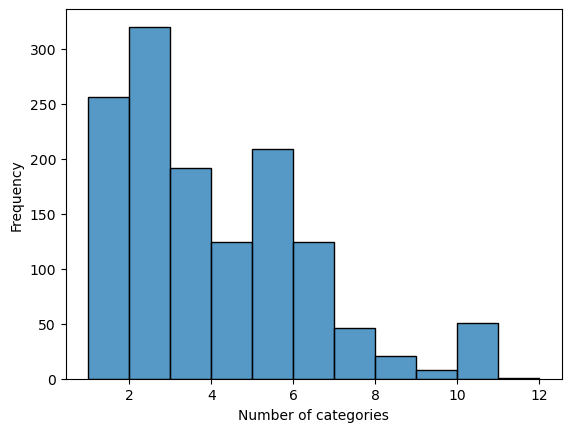

In [19]:
temp = yolosac.loc[categories_bool['Restaurant'], 'category'].map(lambda x : len(x))
sns.histplot(temp, binwidth=1)
plt.xlabel('Number of categories')
plt.ylabel('Frequency')

"Restaurants" can have between 0 and 10 additional categories. Most have 1 additional category.

### Recategorize businesses

In [12]:
def simplify(lst, cats, key='string'):
  for cat in cats:
    if cat in lst:
        return key
  return lst

In [118]:
#yolosac2 = yolosac
yolosac2 = copy.deepcopy(yolosac)

yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, education, 'education')) # School & College
'''
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, rec,'recreation')) # Park
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, beauty, 'beauty')) # Beauty salon
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, health, 'health')) # Doctor & Hospital
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, car, 'car')) # Auto repair shop

yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, retail, 'retail')) # Clothing store

yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, restaurant)) # Restaurant
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, grocery)) # Grocery store
'''
print(yolosac2[yolosac2['category'] == 'education'].info())
print(yolosac2.info())
print()


<class 'pandas.core.frame.DataFrame'>
Index: 543 entries, 22 to 17838
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            543 non-null    object 
 1   gmap_id         543 non-null    object 
 2   category        543 non-null    object 
 3   avg_rating      543 non-null    float64
 4   num_of_reviews  543 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 25.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17938 entries, 0 to 17937
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            17938 non-null  object 
 1   gmap_id         17938 non-null  object 
 2   category        17938 non-null  object 
 3   avg_rating      17938 non-null  float64
 4   num_of_reviews  17938 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 700.8+ KB
None



## Playing with Gensim Key Vectors

Download the KeyVector for an existing model: https://nlp.stanford.edu/projects/glove/

Generate a list of words that are similar to 'restaurant' but not the 'hotel' or 'retail' categories.

In [90]:
sim_to_restaurant_df = pd.DataFrame(columns=['word', 'similarity to restaurant'], data=key_vec.most_similar(positive=['restaurant'], topn=30))

# Manually remove terms that overlap with retail and hotel categories.
sim_to_restaurant = sim_to_restaurant_df.drop(index=[2,4,11,12,13,16,17,18,23,22,26,28,19])['word'].to_list()
print(sim_to_restaurant)

['cafe', 'restaurants', 'dining', 'eatery', 'diner', 'bakery', 'chef', 'pub', 'bistro', 'pizza', 'bar', 'gourmet', 'tavern', 'diners', 'dinner', 'breakfast', 'cafeteria']


Helper function to classify if a phrase belongs in a category

In [19]:
# Classify if a phrase is similar to the words in a list
# comp is a list of words related to a category, e.g. restaurant-related
def is_it_similar(phrase, comp ,threshold):
  words = phrase.split(' ')
  for w in words:
    for c in comp:
      try:
        sim_score = key_vec.similarity(w, c)
      except KeyError:
        sim_score = 0
      if sim_score > threshold:
        return True
  return False

Select the raw categories that are highly similar to restaurant-related words.

In [91]:
restaurant = unique_cat_freq[unique_cat_freq['category'].apply(lambda x : is_it_similar(x, sim_to_restaurant, 0.75))]
restaurant.drop(index=[1383,1435], inplace=True)
print(restaurant)

                             category  count
0                          restaurant   1352
1                fast food restaurant    649
4                  mexican restaurant    429
6                  takeout restaurant    411
9                breakfast restaurant    380
...                               ...    ...
2163              raw food restaurant      1
2166   bar restaurant furniture store      1
2172                 swiss restaurant      1
2286        indian sizzler restaurant      1
2287  north eastern indian restaurant      1

[174 rows x 2 columns]


/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_18033/1818852835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant.drop(index=[1383,1435], inplace=True)


Create a deep copy of business dataframe to modify categories.

In [72]:
yolosac2 = copy.deepcopy(yolosac)

Modify similar categories to restaurant in yolosac2. Note that `simplify()` is defined in "Recategorize Businesses".

In [97]:
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, restaurant['category'].to_list(), 'restaurant')) # School & College

print(yolosac2[yolosac2['category'] == 'restaurant'].shape)
print(yolosac.shape)

(3736, 5)
(17938, 5)


### Recreation

In [38]:
sim_to_rec_df = pd.DataFrame(data=key_vec.most_similar(positive=['park','sport', 'gym'], topn=40))
#sim_to_rec_df = pd.DataFrame(data=key_vec.most_similar(positive=['theater'], topn=20))
# sim_to_rec_df = pd.concat([sim_to_rec_df, pd.DataFrame(key_vec.most_similar(positive=['sport'], topn=20))], ignore_index=True)
sim_to_rec = sim_to_rec_df.iloc[[0,3,13,15,16]][0].to_list()
sim_to_rec = sim_to_rec + ['nature', 'outdoor','gym', 'hike', 'park']
#sim_to_restaurant = sim_to_restaurant_df.drop(index=[2,4,11,12,13,16,17,18,23,22,26,28,19])['word'].to_list()

rec = unique_cat_freq[unique_cat_freq['category'].apply(lambda x : is_it_similar(x, sim_to_rec, 0.7))]
#restaurant.drop(index=[1383,1435], inplace=True)
rec.drop(index=[123,165,172,209,267], inplace=True)

park = similarCats('park')
rec = rec['category'].to_list() + [x for x in park if x not in rec]
print(rec)

['park', 'gym', 'fitness center', 'physical fitness program', 'recreation center', 'dog park', 'sports massage therapist', 'sports complex', 'indoor lodging', 'outdoor sports store', 'public swimming pool', 'swimming pool repair service', 'swimming pool supply store', 'baseball field', 'soccer field', 'rv park', 'pool hall', 'pool cleaning service', 'business park', 'rock climbing gym', 'sports equipment rental service', 'stadium', 'skateboard park', 'sports club', 'nature preserve', 'swimming pool', 'swimming pool contractor', 'amusement park', 'state park', 'indoor playground', 'recreational vehicle rental agency', 'basketball club', 'memorial park', 'city park', 'park & ride', 'soccer club', 'sports nutrition store', 'boxing gym', 'sports activity location', 'sports medicine physician', 'natural stone supplier', 'outdoor clothing and equipment shop', 'water park', 'arena', 'sports medicine clinic', 'outdoor activity organiser', 'theme park', 'baseball club', 'baseball goods store', 

/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_18033/2081792627.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec.drop(index=[123,165,172,209,267], inplace=True)


In [47]:
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, rec, 'recreation'))
print(yolosac2[yolosac2['category'] == 'recreation'].iloc[:50])
print(yolosac2[yolosac2['category'] == 'recreation'].shape)

                                                  name  \
17                         Ferreira's Health & Fitness   
19                     Howe Park Duck and Fishing Pond   
36         Observation Deck in Cosumnes River Preserve   
37   Bruss Ranch & CalOak Oberhasli Dairy Goats; Br...   
46                                     Anytime Fitness   
54                                   Intel Folsom Pond   
62                                           JRM Ranch   
65                                            Leslie's   
100                                  Kaia FIT Woodland   
135                        Ferreira's Health & Fitness   
137                    Howe Park Duck and Fishing Pond   
154        Observation Deck in Cosumnes River Preserve   
155  Bruss Ranch & CalOak Oberhasli Dairy Goats; Br...   
164                                    Anytime Fitness   
172                                  Intel Folsom Pond   
180                                          JRM Ranch   
183           

### Education

In [77]:
sim_to_edu_df = pd.DataFrame(data=key_vec.most_similar(positive=['school'], topn=30))
sim_to_edu = sim_to_edu_df[0].iloc[[0,1,2,4,7,8,11,14]].to_list()
sim_to_edu.append('library')

edu = unique_cat_freq[unique_cat_freq['category'].apply(lambda x : is_it_similar(x, sim_to_edu, 0.75))]
edu.drop(index=[163,288], inplace=True)

/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_18033/1095703954.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edu.drop(index=[163,288], inplace=True)


In [121]:
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, edu['category'].to_list(), 'education'))
print(yolosac2[yolosac2['category'] == 'education'].iloc[:50])
print(yolosac2[yolosac2['category'] == 'education'].shape)


                                                   name  \
22                           John F Kennedy High School   
75                      UC Davis: Sciences Lecture Hall   
76                                Sciences Lab Building   
77                                         Wellman Hall   
78            UC Davis Earth And Physical Sciences Bldg   
79                       Mathematical Sciences Building   
84                           ASUCD Experimental College   
85                                          Sproul Hall   
140                          John F Kennedy High School   
193                     UC Davis: Sciences Lecture Hall   
194                               Sciences Lab Building   
195                                        Wellman Hall   
196           UC Davis Earth And Physical Sciences Bldg   
197                      Mathematical Sciences Building   
202                          ASUCD Experimental College   
203                                         Sproul Hall 

### Health

In [20]:
sim_to_health = pd.DataFrame(data=key_vec.most_similar(positive=['doctor', 'hospital'], topn=30))
sim_to_health = sim_to_health[0].iloc[[0,1,2,3,8,12,15,19]].to_list()
sim_to_health.append('pharmacy')

health = unique_cat_freq[unique_cat_freq['category'].apply(lambda x : is_it_similar(x, sim_to_health, 0.75))]
health.drop(index=[171,767,796], inplace=True)

/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_18033/3942473280.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  health.drop(index=[171,767,796], inplace=True)


In [81]:
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, health['category'].to_list(), 'health'))
print(yolosac2[yolosac2['category'] == 'health'].iloc[:50])
print(yolosac2[yolosac2['category'] == 'health'].shape)

                                                  name  \
26                               AllMed Medical Center   
35             Children's Receiving Home of Sacramento   
47                         Empire Parkway Dental Group   
55                Sacramento Community Clinic - Dental   
92     Kaiser Permanente Medical Center Steven Rose MD   
102       Woodland Healthcare: Cammarosano Camine A MD   
106                            Griffin & Reed Eye Care   
117            Good Neighbors Child Development Center   
144                              AllMed Medical Center   
153            Children's Receiving Home of Sacramento   
165                        Empire Parkway Dental Group   
173               Sacramento Community Clinic - Dental   
210    Kaiser Permanente Medical Center Steven Rose MD   
220       Woodland Healthcare: Cammarosano Camine A MD   
224                            Griffin & Reed Eye Care   
235            Good Neighbors Child Development Center   
237           

### Beauty

In [46]:
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, beauty, 'beauty'))
print(yolosac2[yolosac2['category'] == 'beauty'].iloc[:50])
print(yolosac2[yolosac2['category'] == 'beauty'].shape)

                                                  name  \
0                                       Aurora Massage   
1                                       Orient Massage   
11                       Caballo Bronco Barber Styling   
13                         Melting Point Massage & Spa   
14                        ANKANG Massage & Reflexology   
15                                       Sweetness spa   
24                                          Hair Story   
32                               Images II Barber Shop   
52                               La Coupe Maison Salon   
68                                       City Haircuts   
89                              Violet Massage Therapy   
98                   SL8 Fitness & Nutrition for Women   
103                                          New Image   
104                               Classic Beauty Salon   
118                                     Aurora Massage   
119                                     Orient Massage   
129           

### Auto

In [48]:
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, car, 'auto'))
print(yolosac2[yolosac2['category'] == 'auto'].iloc[:50])
print(yolosac2[yolosac2['category'] == 'auto'].shape)

                                                  name  \
8                                 Dan's Mission Towing   
25                                             Chevron   
41                                   Petrol Auto Sales   
42                     Nissan Elk Grove Service Center   
56                                    Gasca Auto Glass   
66                                         BROS LIQUOR   
94                                          Speed Bird   
126                               Dan's Mission Towing   
143                                            Chevron   
159                                  Petrol Auto Sales   
160                    Nissan Elk Grove Service Center   
174                                   Gasca Auto Glass   
184                                        BROS LIQUOR   
212                                         Speed Bird   
255         Top Rank Heating and Air Conditioning Inc.   
257                                      Stellar Built   
259           

### Hotel

In [57]:
sim_to_hotel = pd.DataFrame(data=key_vec.most_similar(positive=['hotel'],negative=['restaurant'], topn=30))
'''sim_to_health = sim_to_health[0].iloc[[0,1,2,3,8,12,15,19]].to_list()
sim_to_health.append('pharmacy')

health = unique_cat_freq[unique_cat_freq['category'].apply(lambda x : is_it_similar(x, sim_to_health, 0.75))]
health.drop(index=[171,767,796], inplace=True)'''

yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, hotel, 'hotel'))
print(yolosac2[yolosac2['category'] == 'hotel'].iloc[:50])
print(yolosac2[yolosac2['category'] == 'hotel'].shape)

                                  name                                gmap_id  \
23                     Coventry Square  0x809ade1cffbf622d:0x128b50049b1fd6ee   
141                    Coventry Square  0x809ade1cffbf622d:0x128b50049b1fd6ee   
239                    Lexington Hills  0x809ae45b73998dbf:0x552d1d12862aa9e9   
275                      The UPS Store  0x809ac0ad82ea42b1:0xb915efb1fdee22d2   
448           The Center at District56  0x809ac7901af16e5d:0x14c3c77a9d3b8fa4   
562                 Delta King Theater  0x809ad6cce8ffb845:0xe4c122b6b1656c08   
632                 Windmill Vineyards  0x8084c4c437a574bb:0x3a9ac4d7881f0f7a   
643              Fair Oaks Office Park  0x809adb0cfef12601:0xc47fcb1ccdbe5dcb   
761          Power Inn Industrial Park  0x809adad3ae47596f:0x392ccd01a739bee4   
792                Valley Oak Ballroom  0x809ac6468d3e933b:0x592f66a1941f2121   
822         Office Depot Tech Services  0x809ae4173fc1516f:0x74a1b325fca4f5a4   
850           Natomas Corpor

### Groceries

In [60]:
sim_to_groc = pd.DataFrame(data=key_vec.most_similar(positive=['groceries', 'food'], topn=30))
sim_to_groc = ['supermarket']
grocery = unique_cat_freq[unique_cat_freq['category'].apply(lambda x : is_it_similar(x, sim_to_groc, 0.75))]
'''sim_to_health = sim_to_health[0].iloc[[0,1,2,3,8,12,15,19]].to_list()
sim_to_health.append('pharmacy')

health = unique_cat_freq[unique_cat_freq['category'].apply(lambda x : is_it_similar(x, sim_to_health, 0.75))]
health.drop(index=[171,767,796], inplace=True)'''

"sim_to_health = sim_to_health[0].iloc[[0,1,2,3,8,12,15,19]].to_list()\nsim_to_health.append('pharmacy')\n\nhealth = unique_cat_freq[unique_cat_freq['category'].apply(lambda x : is_it_similar(x, sim_to_health, 0.75))]\nhealth.drop(index=[171,767,796], inplace=True)"

In [63]:
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, grocery['category'].to_list(), 'grocery'))
print(yolosac2[yolosac2['category'] == 'grocery'].iloc[:50])
print(yolosac2[yolosac2['category'] == 'grocery'].shape)

                                     name  \
66                            BROS LIQUOR   
184                           BROS LIQUOR   
242                               Myu Myu   
462             International Food Market   
750             India Fiji Food & Fashion   
758            Hamisha Bahar Halal Market   
918                           Stop & Shop   
950                          World Market   
1191                       Target Grocery   
1410                        Mike's Liquor   
1482                       Target Grocery   
1551                          Desi Bazaar   
1719                          Dollar Tree   
1740              Tarad Thai Asian Market   
1783                  Lauj Enterprise Inc   
1861             Cigarette & vape forever   
1942          Island of the Moon Apiaries   
2145  Nathan And Fam Lee Strawberry Stand   
2165                 La Superior Mercados   
2254                        Hana's Corner   
2292                             Sinclair   
2404      

### Retail

In [66]:
sim_to_retail = pd.DataFrame(data=key_vec.most_similar(positive=['clothes','store'], topn=30))
sim_to_retail = sim_to_retail.iloc[[0,1,2,5,6,7,22,25]][0].to_list()
retail = unique_cat_freq[unique_cat_freq['category'].apply(lambda x : is_it_similar(x, sim_to_retail, 0.75))]



In [69]:
retail = similarCats('clothing store')
# Remove stores that sell food (grocery stores)
for x in retail:
  if is_it_similar(x,['supermarket'],0.8):
    retail.remove(x)

print(*retail, sep='\n')

clothing store
men's clothing store
women's clothing store
shoe store
department store
children's clothing store
fashion accessories store
jeans shop
t-shirt store
swimwear store
baby store
sporting goods store
sportswear store
outdoor sports store
running store
outlet store
toy store
plus size clothing store
camping store
discount store
baby clothing store
lingerie store
dress store
underwear store
jewelry store
custom t-shirt store
luggage store
sunglasses store
youth clothing store
baseball goods store
electronics store
work clothes store
skateboard shop
home goods store
boutique
skate shop
outdoor clothing and equipment shop
watch store
vintage clothing store
clothes and fabric manufacturer
clothing supplier
outerwear store
novelty store
used clothing store
tuxedo shop
snowboard shop
golf shop
furniture store
western apparel store
craft store
outdoor activity organiser
surf shop
hunting and fishing store
clothes market
protective clothing supplier
bicycle store
boot store
exercise 

In [71]:
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, retail, 'retail'))
print(yolosac2[yolosac2['category'] == 'retail'].iloc[:50])
print(yolosac2[yolosac2['category'] == 'retail'].shape)

                                                 name  \
6                      Valley Gaming & Billiards Home   
51                              Apricot Lane Boutique   
59                                    Creekside Signs   
63                    California Check Cashing Stores   
114                         Circle M Cigarette Market   
124                    Valley Gaming & Billiards Home   
169                             Apricot Lane Boutique   
177                                   Creekside Signs   
181                   California Check Cashing Stores   
232                         Circle M Cigarette Market   
270                              Dixie's Paws & Claws   
275                                     The UPS Store   
294                                       Keep it Lit   
329                                 Four1five Designs   
334                            Shop & Save Smoke Shop   
349                                 Metro by T-Mobile   
364                            

## TESTING

In [82]:
yolosac2 = copy.deepcopy(yolosac)

In [83]:
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, edu['category'].to_list(), 'education'))
print(yolosac2[yolosac2['category'] == 'education'].iloc[:50])
print(yolosac2[yolosac2['category'] == 'education'].shape)

                                                   name  \
22                           John F Kennedy High School   
75                      UC Davis: Sciences Lecture Hall   
76                                Sciences Lab Building   
77                                         Wellman Hall   
78            UC Davis Earth And Physical Sciences Bldg   
79                       Mathematical Sciences Building   
84                           ASUCD Experimental College   
85                                          Sproul Hall   
140                          John F Kennedy High School   
193                     UC Davis: Sciences Lecture Hall   
194                               Sciences Lab Building   
195                                        Wellman Hall   
196           UC Davis Earth And Physical Sciences Bldg   
197                      Mathematical Sciences Building   
202                          ASUCD Experimental College   
203                                         Sproul Hall 

In [84]:
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, health['category'].to_list(), 'health'))
print(yolosac2[yolosac2['category'] == 'health'].iloc[:50])
print(yolosac2[yolosac2['category'] == 'health'].shape)

                                                  name  \
26                               AllMed Medical Center   
35             Children's Receiving Home of Sacramento   
47                         Empire Parkway Dental Group   
55                Sacramento Community Clinic - Dental   
92     Kaiser Permanente Medical Center Steven Rose MD   
102       Woodland Healthcare: Cammarosano Camine A MD   
106                            Griffin & Reed Eye Care   
117            Good Neighbors Child Development Center   
144                              AllMed Medical Center   
153            Children's Receiving Home of Sacramento   
165                        Empire Parkway Dental Group   
173               Sacramento Community Clinic - Dental   
210    Kaiser Permanente Medical Center Steven Rose MD   
220       Woodland Healthcare: Cammarosano Camine A MD   
224                            Griffin & Reed Eye Care   
235            Good Neighbors Child Development Center   
237           

In [85]:
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, beauty, 'beauty'))
print(yolosac2[yolosac2['category'] == 'beauty'].iloc[:50])
print(yolosac2[yolosac2['category'] == 'beauty'].shape)

                                                  name  \
0                                       Aurora Massage   
1                                       Orient Massage   
11                       Caballo Bronco Barber Styling   
13                         Melting Point Massage & Spa   
14                        ANKANG Massage & Reflexology   
15                                       Sweetness spa   
24                                          Hair Story   
32                               Images II Barber Shop   
52                               La Coupe Maison Salon   
68                                       City Haircuts   
89                              Violet Massage Therapy   
98                   SL8 Fitness & Nutrition for Women   
103                                          New Image   
104                               Classic Beauty Salon   
118                                     Aurora Massage   
119                                     Orient Massage   
129           

In [86]:
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, rec, 'recreation'))
print(yolosac2[yolosac2['category'] == 'recreation'].iloc[:50])
print(yolosac2[yolosac2['category'] == 'recreation'].shape)

                                                  name  \
17                         Ferreira's Health & Fitness   
19                     Howe Park Duck and Fishing Pond   
36         Observation Deck in Cosumnes River Preserve   
37   Bruss Ranch & CalOak Oberhasli Dairy Goats; Br...   
46                                     Anytime Fitness   
54                                   Intel Folsom Pond   
62                                           JRM Ranch   
65                                            Leslie's   
100                                  Kaia FIT Woodland   
135                        Ferreira's Health & Fitness   
137                    Howe Park Duck and Fishing Pond   
154        Observation Deck in Cosumnes River Preserve   
155  Bruss Ranch & CalOak Oberhasli Dairy Goats; Br...   
164                                    Anytime Fitness   
172                                  Intel Folsom Pond   
180                                          JRM Ranch   
183           

In [87]:
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, grocery['category'].to_list(), 'grocery'))
print(yolosac2[yolosac2['category'] == 'grocery'].iloc[:50])
print(yolosac2[yolosac2['category'] == 'grocery'].shape)

                                     name  \
66                            BROS LIQUOR   
184                           BROS LIQUOR   
242                               Myu Myu   
462             International Food Market   
750             India Fiji Food & Fashion   
758            Hamisha Bahar Halal Market   
918                           Stop & Shop   
950                          World Market   
1191                       Target Grocery   
1410                        Mike's Liquor   
1482                       Target Grocery   
1551                          Desi Bazaar   
1719                          Dollar Tree   
1740              Tarad Thai Asian Market   
1783                  Lauj Enterprise Inc   
1861             Cigarette & vape forever   
1942          Island of the Moon Apiaries   
2145  Nathan And Fam Lee Strawberry Stand   
2165                 La Superior Mercados   
2254                        Hana's Corner   
2292                             Sinclair   
2404      

In [88]:
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, retail, 'retail'))
print(yolosac2[yolosac2['category'] == 'retail'].iloc[:50])
print(yolosac2[yolosac2['category'] == 'retail'].shape)

                                                 name  \
6                      Valley Gaming & Billiards Home   
51                              Apricot Lane Boutique   
59                                    Creekside Signs   
63                    California Check Cashing Stores   
114                         Circle M Cigarette Market   
124                    Valley Gaming & Billiards Home   
169                             Apricot Lane Boutique   
177                                   Creekside Signs   
181                   California Check Cashing Stores   
232                         Circle M Cigarette Market   
270                              Dixie's Paws & Claws   
275                                     The UPS Store   
294                                       Keep it Lit   
329                                 Four1five Designs   
334                            Shop & Save Smoke Shop   
349                                 Metro by T-Mobile   
364                            

In [89]:
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, car, 'auto'))
print(yolosac2[yolosac2['category'] == 'auto'].iloc[:50])
print(yolosac2[yolosac2['category'] == 'auto'].shape)

                                                  name  \
8                                 Dan's Mission Towing   
25                                             Chevron   
41                                   Petrol Auto Sales   
42                     Nissan Elk Grove Service Center   
56                                    Gasca Auto Glass   
94                                          Speed Bird   
126                               Dan's Mission Towing   
143                                            Chevron   
159                                  Petrol Auto Sales   
160                    Nissan Elk Grove Service Center   
174                                   Gasca Auto Glass   
212                                         Speed Bird   
255         Top Rank Heating and Air Conditioning Inc.   
257                                      Stellar Built   
259                             Mercedes International   
272                            Triple Crown Automotive   
278           

In [92]:
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, restaurant['category'].to_list(), 'restaurant')) # School & College

print(yolosac2[yolosac2['category'] == 'restaurant'].iloc[:50])
print(yolosac[yolosac2['category'] == 'restaurant'].shape)

                                 name                                gmap_id  \
28                        China House  0x809ae410bb4b79db:0x8e53e91c4a62cfcd   
48               Kiki's Chicken Place  0x809ae58e5b6f8889:0x997c522d3d5cf906   
81                         Carl's Jr.  0x80852990182f7d55:0xe7374fc8442789f1   
99                       Carlton Club  0x8084d0e5f234f735:0x782262f8c6962382   
105                 Costco Food Court  0x8084d155d59bbe79:0xea9392e201d6ec6f   
146                       China House  0x809ae410bb4b79db:0x8e53e91c4a62cfcd   
166              Kiki's Chicken Place  0x809ae58e5b6f8889:0x997c522d3d5cf906   
199                        Carl's Jr.  0x80852990182f7d55:0xe7374fc8442789f1   
217                      Carlton Club  0x8084d0e5f234f735:0x782262f8c6962382   
223                 Costco Food Court  0x8084d155d59bbe79:0xea9392e201d6ec6f   
238                          Cinnabon  0x809ade2407727363:0x6cb49bc8ac7e5da0   
243                  True North Pizza  0

In [93]:
yolosac2.to_csv('data/yolosac2.csv')

In [97]:
def simple_category(x):
  return x in ['restaurant', 'recreation', 'grocery', 'health', 'beauty', 'retail', 'auto', 'education']

yolosac3 = yolosac2[yolosac2['category'].apply(lambda x : simple_category(x))]
# restaurant = unique_cat_freq[unique_cat_freq['category'].apply(lambda x : is_it_similar(x, sim_to_restaurant, 0.75))]
yolosac3.to_csv('yolosac3.csv')

**TO DO: Repeat process for all categories**
Gensim seems to work better for some categories than others. For example, Parks and Beauty have better results from the correlation matrix.
* Parks & Rec ~1,200 using Gensim and correlation
* Restaurants (done) ~ 3,000 using Gensim
* Education (done) ~350 using Gensim
* Health (done) ~750 using Gensim (including pharmacies)
* Beauty ~1350 using correlation
* Auto ~2200 using correlation (including gas stations)
* Hotel
* Food retail (i.e. grocery stores, markets) ~450 using Gensim
* Other retail (i.e. clothing, home improvement, etc) ~2100 using correlation (grocery removed)
* Entertainment

**Can we develop a method for categorization that takes into account all categories? For example, "brow bar" could be intepreted as a restaurant or beauty establishment from the separate parts of the phrase.**
- Develop ranking based on presence of categories similar to the 10 general categories
- A store that is also a clinic will have more store-related categories. It would be classified as a store.
